<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# Chapter 4: Implementing a GPT model from Scratch To Generate Text 

In [2]:
from importlib.metadata import version

import matplotlib
import tiktoken
import torch

print("matplotlib version:", version("matplotlib"))
print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

matplotlib version: 3.3.2
torch version: 2.2.2
tiktoken version: 0.7.0


- 在本章中，我们实现了一个类似GPT的大型语言模型（LLM）架构；下一章将重点介绍这个LLM的训练。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/01.webp" width="500px">

1. 编码一个类似GPT的大型语言模型（LLM）
2. 对layer activation进行normalizing处理，让训练更稳定
3. 在深度神经网络中添加shortcut connections，让训练更高效
4. 实现transformer块来创建不同大小的GPT模型
5. 计算GPT模型的参数数量和存储需求

## 4.1 Coding an LLM architecture

- 第一章讨论了像GPT和Llama这样的模型，它们基于原始Transformer架构的解码器部分，顺序地生成单词。
- 因此，这些大型语言模型（LLM）通常被称为“类似解码器”的LLM。
- 与传统深度学习模型相比，LLM的规模更大，这主要是因为它们拥有大量的参数，而不是代码量的多少。
- 我们会发现，在LLM的架构中，许多元素是重复的。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/02.webp" width="400px">

- Configuration details for the 124 million parameter GPT-2 model include:

In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

这里我们使用简短的变量名，以避免后续代码行过长。
- "vocab_size" 表示词汇表的大小为50,257个单词，这是由第2章讨论的BPE分词器支持的。
- "context_length" 表示模型的最大输入token数，这是由第2章介绍的position embedding所支持的。
- "emb_dim" 是token embedding的大小，将每个inputs token转换为768维的向量。
- "n_heads" 是多头注意力机制中注意力头的数量，这在第3章中实现。
- "n_layers" 是模型中Transformer块的数量，我们将在后续章节中实现。
- "drop_rate" 是Dropout机制的强度，第3章中讨论了这一点；0.1表示在训练过程中丢弃10%的隐藏单元，以减轻过拟合。
- "qkv_bias" 决定多头注意力机制中的`Linear`层在计算查询（Q）、键（K）和值（V）张量时是否包括偏置向量（来自第3章）；我们将禁用此选项
  这是现代大型语言模型中的标准做法；然而，当我们在第6章从OpenAI加载预训练的GPT-2权重进行重新实现时，会重新讨论这一点。

使用上述配置，我们将在本节开始实现一个GPT占位架构（DummyGPTModel），如图4.3所示。这将为我们提供一个整体视图，展示所有部分如何组合在一起，以及在接下来的部分中组装完整的GPT模型架构所需的其他组件。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/03.webp" width="500px">

In [4]:
import torch
import torch.nn as nn


class DummyGPTModel(nn.Module): # 定义DummyGPTModel类，继承nn.Module nn.module是pytorch体系下所有神经网络的基类
    def __init__(self, cfg):# 定义初始化方法  self是对当前实例的应用，cfg是一个常见的缩写，代表“configuration”（配置）
        super().__init__()# 调用父类的初始化方法
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])# 定义词元嵌入层
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])# 定义位置嵌入层
        self.drop_emb = nn.Dropout(cfg["drop_rate"])# 定义丢弃层
        
        # Use a placeholder for TransformerBlock
        self.trf_blocks = nn.Sequential(# 定义顺序容器，用于存放transformer块
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])# 使用占位transformer块
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])# 使用占位层归一化
        self.out_head = nn.Linear(# 定义线性层
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):# 定义前向传播方法
        batch_size, seq_len = in_idx.shape# 获取批量大小和序列长度
        tok_embeds = self.tok_emb(in_idx)# 获取词元嵌入
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))# 获取位置嵌入
        x = tok_embeds + pos_embeds# 合并嵌入
        x = self.drop_emb(x)# 应用丢弃层
        x = self.trf_blocks(x)# 应用transformer块
        x = self.final_norm(x)# 应用归一化层
        logits = self.out_head(x)# 计算输出
        return logits# 返回输出


class DummyTransformerBlock(nn.Module):# 定义占位transformer块类，继承nn.Module
    def __init__(self, cfg):# 定义初始化方法
        super().__init__()
        # A simple placeholder 一个简单的占位符

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):# 定义占位层归一化类，继承nn.Module
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

- 此代码中的DummyGPTModel类使用PyTorch的神经网络模块（nn.Module）定义了一个GPT类模型的简化版本。DummyGPTModel类中的模型架构包括标记嵌入和位置嵌入、dropout、一系列Transformer模块（DummyTransformerBlock）、最终层归一化（DummyLayerNorm）以及一个线性输出层（out_head）。配置信息通过Python字典传递，例如我们之前创建的GPT_CONFIG_124M字典。
- forward方法描述了数据在模型中的流动过程：它计算输入索引的标记嵌入和位置嵌入，应用dropout，通过Transformer模块处理数据，应用归一化，并最终通过线性输出层生成logits。
- 上面的代码已经具备功能，在本节的后续部分，我们将准备输入数据，之后可以看到其运行结果。然而，就目前而言，请注意在上面的代码中，我们为Transformer模块和层归一化使用了占位符（DummyLayerNorm和DummyTransformerBlock），这些占位符我们将在后续部分中进行开发。
- 接下来，我们将准备输入数据并初始化一个新的GPT模型，以演示其使用方法。基于我们在第2章中看到的图像（当时我们编写了分词器代码），图4.4提供了GPT模型中数据流入和流出的高级概述。

我们简单回顾一下流程。

- 将输入语句“Every effort moves you“ 切成token---> Every effort moves you。
- 然后token转id： Every effort moves you---> 6109 3626 6100 345
- 接着每个token_id都转换为embedding vector： 6109--> $$
 \left\{
 \begin{matrix}
   a1 \\
   a2 \\
   ...\\
   a768
  \end{matrix}
  \right\} \tag{2}
$$
通过GPT模型处理以后，每一个768维的token embedding都对应一个768维的output vector输出。
预测下一个词forward。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/04.webp?123" width="500px">

In [5]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

txt1 = "Every effort moves you"
txt2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
print(batch)
batch = torch.stack(batch, dim=0)#使用torch.stack函数将batch列表中的张量沿着一个新的维度（dim=0）堆叠起来。
print(batch)

[tensor([6109, 3626, 6100,  345]), tensor([6109, 1110, 6622,  257])]
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


加载配置文件初始化GPT模型，让batch数据转化为logits 。输入的batch dimension是torch.Size([2, 4]) ，输入的logits dim是 torch.Size([2, 4, 50257])。这里多出来的一个维度，就如同前面提到的， 50257是词表大小，可以近似理解为在每一个词上的概率分布。

输出张量有两行，分别对应两个文本样本。每个文本样本包含4个标记；每个标记都是一个50,257维的向量，这与分词器的词汇表大小相匹配。
嵌入有50,257维，是因为这些维度中的每一个都指向词汇表中的一个唯一标记。在本章末尾，当我们实现后处理代码时，我们会将这些50,257维的向量转换回标记ID，然后可以将它们解码为单词。
现在，我们已经从整体上了解了GPT架构及其输入和输出，接下来我们将在接下来的部分中编写各个占位符的代码，首先是从真正的层归一化类开始，该类将替换先前代码中的DummyLayerNorm。

---

**Note**

- If you are running this code on Windows or Linux, the resulting values above may look like as follows:
    
```
Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)
```

- Since these are just random numbers, this is not a reason for concern, and you can proceed with the remainder of the chapter without issues

---

## 4.2 Normalizing activations with layer normalization

用许多层训练深度神经网络有时会因梯度消失或梯度爆炸等问题而变得具有挑战性。这些问题导致训练动态不稳定，并且难以使网络有效调整其权重，这意味着学习过程难以找到一组参数（权重），以使神经网络最小化损失函数。换句话说，网络难以学习数据中的基本模式，难以进行准确的预测或决策。

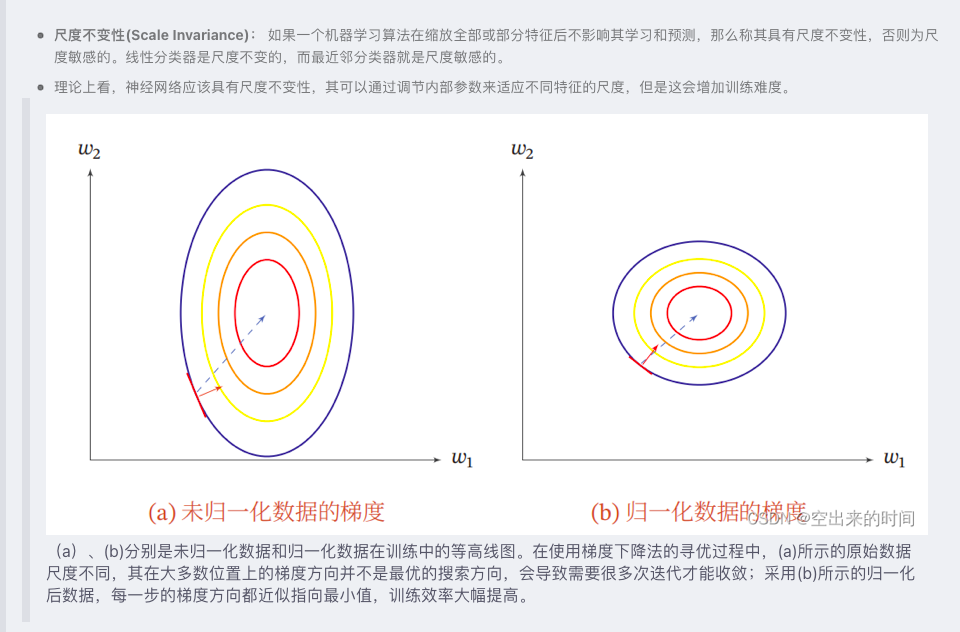

- 层归一化（Layer normalization），也称为LayerNorm（Ba等人，2016），将神经网络层的激活值围绕均值0进行中心化，并将其方差归一化为1。
- 这有助于稳定训练过程，并使模型能够更快地收敛到有效的权重。
- 在即将实现的Transformer模块中，层归一化被应用于多头注意力模块之前和之后；同时，在最终输出层之前也会应用层归一化。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/05.webp" width="400px">

- 让我们通过一个简单的神经网络层传递一个小输入样本来看看层归一化是如何工作的：

In [7]:
torch.manual_seed(123)

# create 2 training examples with 5 dimensions (features) each
batch_example = torch.randn(2, 5) 

layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())# 创建顺序容器，包括线性层和ReLU激活函数
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


我们编写的神经网络层由一个线性层和一个非线性激活函数ReLU（整流线性单元的缩写）组成，这是神经网络中的标准激活函数。如果您不熟悉ReLU，它只是将负输入设为0，确保层只输出正值，这解释了为什么生成的层输出不包含任何负值。（请注意，我们将在GPT中使用另一种更复杂的激活函数，我们将在下一节中介绍它。

- 让我们为上面两个输入中的每一个计算均值和方差：

In [8]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


- out_norm.mean(dim=-1, keepdim=True)
- 归一化是独立应用于两个输入（行）中的每一个的；使用dim=-1是在最后一个维度（在本例中为特征维度）上而不是在行维度上进行计算

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/06.webp" width="400px">

- 从输入中减去均值并除以方差的平方根（标准差）可以使输入在列（特征）维度上的均值变为0，方差变为1，从而实现中心化：

In [9]:
out_norm = (out - mean) / torch.sqrt(var)
print("Normalized layer outputs:\n", out_norm)

mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 每个输入都以0为中心，且方差为单位值1；为了提高可读性，我们可以禁用PyTorch的科学计数法：

In [10]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


- 在上面，我们对每个输入的特征进行了归一化。
- 现在，使用相同的思路，我们可以实现一个LayerNorm class：  
在本节中，我们已经逐步编写和应用了层归一化。现在让我们将此过程封装在一个PyTorch模块中，以便我们稍后在GPT模型中使用：

In [11]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)#计算均值
        var = x.var(dim=-1, keepdim=True, unbiased=False)#计算方差
        norm_x = (x - mean) / torch.sqrt(var + self.eps)#进行归一化
        return self.scale * norm_x + self.shift#进行归一化后的输出

**Scale and shift**
- 除了normalization之外，我们还添加了两个可训练参数，即scale和shift参数。
- 初始的scale（值为1）和shift（值为0）值没有任何效果；然而，scale和shift是可训练的参数，LLM会在训练过程中自动调整它们，如果确定这样做可以提高模型在其训练任务上的性能。
- 在计算方差的平方根之前，我们还添加了一个较小的值（eps）；这是为了避免在方差为0时出现除以零的错误。 

**Biased variance**
- 在上述方差计算中，设置unbiased=False意味着使用公式 
$\frac{\sum_i (x_i - \bar{x})^2}{n}$
来计算方差，其中n是样本大小（这里是特征或列的数量）；这个公式不包括Bessel's correction（在分母中使用n-1，因此提供了方差的有偏估计。
对于LLM来说，嵌入维度n非常大，使用n和n-1之间的差异可以忽略不计。
- 然而，GPT-2在归一化层中使用了有偏方差进行训练，这就是为了与我们将在后面章节中加载的预训练权重兼容，我们也采用了这个设置。

现在让我们实际尝试LayerNorm模块并将其应用于批处理输入：

In [12]:
ln = LayerNorm(emb_dim=5)#创建LayerNorm实例
out_ln = ln(batch_example)#对批处理实例应用LayerNorm
out_ln

tensor([[ 0.5528,  1.0693, -0.0223,  0.2656, -1.8654],
        [ 0.9087, -1.3767, -0.9564,  1.1304,  0.2940]], grad_fn=<AddBackward0>)

In [13]:
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)

print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/07.webp" width="400px">

## 4.3 Implementing a feed forward network with GELU activations
## 4.3实现一个带有GELU激活函数的前馈神经网络

- 在本节中，我们将实现一个小型神经网络子模块，该模块用作大型语言模型（LLMs）中Transformer块的一部分。
- 我们从激活函数开始讲起。
- 在深度学习中，由于ReLU（Rectified Linear Unit，修正线性单元）激活函数在各种神经网络架构中的简单性和有效性，它经常被使用。
- 然而，在大型语言模型中，除了传统的ReLU之外，还使用了其他各种类型的激活函数。其中两个值得注意的例子是GELU（Gaussian Error Linear Unit，高斯误差线性单元）和SwiGLU（Swish-Gated Linear Unit，Swish门控线性单元）。
- GELU和SwiGLU是更复杂的、平滑的激活函数，分别结合了高斯和sigmoid门控线性单元，与ReLU的更简单、分段线性函数不同，它们为深度学习模型提供了更好的性能。

- GELU（Gaussian Error Linear Unit，高斯误差线性单元）（Hendrycks和Gimpel 2016）可以通过多种方式实现；其精确版本定义为GELU(x) = x·Φ(x)，其中Φ(x)是标准高斯分布的累积分布函数。
- 在实际应用中，通常采用一种计算成本更低的近似实现：$\text{GELU}(x) \approx 0.5 \cdot x \cdot \left(1 + \tanh\left[\sqrt{\frac{2}{\pi}} \cdot \left(x + 0.044715 \cdot x^3\right)\right]\right) $（原始的GPT-2模型也是使用这种近似进行训练的）。

In [14]:
class GELU(nn.Module):# 定义GELU类，继承nn.Module
    def __init__(self):
        super().__init__()

    def forward(self, x):# 定义前向传播方法
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

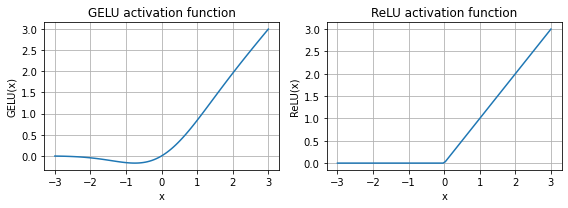

In [15]:
#接下来，为了了解这个GELU函数的样子以及它与ReLU函数的比较，让我们将这些函数并排绘制出来：
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()

- 我们可以看到，ReLU是一个分段线性函数，如果输入为正，则直接输出输入；否则，输出零。
- GELU是一个平滑的非线性函数，它近似于ReLU，但对于负值（除了在大约-0.75处）具有非零梯度。
- 接下来，让我们实现稍后在大型语言模型（LLM）的Transformer块中将要使用的小型神经网络模块FeedForward：

如图4.8所示，GELU的平滑性在训练过程中可以导致更好的优化特性，因为它允许对模型参数进行更细致的调整。相比之下，ReLU在零处有一个尖锐的拐角，这有时会使优化变得更困难，尤其是在非常深或具有复杂架构的网络中。此外，与ReLU不同，ReLU对于任何负输入输出为零，GELU允许负值有一个小的非零输出。这一特性意味着在训练过程中，接收负输入的神经元仍然可以为学习过程做出贡献，尽管贡献比正输入小。

接下来，让我们使用GELU函数来实现一个小型神经网络模块FeedForward，我们将在LLM的transformer块中使用它：

In [16]:
class FeedForward(nn.Module): # 定义FeedForward类，继承nn.Module
    def __init__(self, cfg):# 初始化方法
        super().__init__()# 调用父类的初始化方法
        self.layers = nn.Sequential( # 使用顺序容器定义网络层
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),# 线性层1，进行线性变化，$ y=W x+ b
            GELU(),# GELU激活函数
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),# 线性层2
        )

    def forward(self, x):# 定义前向传播方法
        return self.layers(x)# 返回网络层的输出

In [17]:
print(GPT_CONFIG_124M["emb_dim"])

768


如前面的代码所示，FeedForward模块是一个由两个线性层和一个GELU激活函数组成的小型神经网络。在拥有1.24亿参数的GPT模型中，它通过GPT_CONFIG_124M字典接收具有嵌入大小为768的词元输入批次，其中GPT_CONFIG_124M[“emb_dim”] = 768。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/09.webp?12" width="400px">

In [18]:
ffn = FeedForward(GPT_CONFIG_124M)

# input shape: [batch_size, num_token, emb_size]
x = torch.rand(2, 3, 768) 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/10.webp" width="400px">

我们在本节中实现的FeedForward模块在增强模型从数据中学习和泛化数据的能力方面起着至关重要的作用。虽然这个模块的输入和输出维度是相同的，但它通过第一个线性层在内部将嵌入维度扩展到更高维空间，如图4.10所示。这种扩展之后是一个非线性的GELU激活，然后通过第二次线性变换收缩回原始维度。这种设计允许探索更丰富的表示空间。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/11.webp" width="400px">

## 4.4 Adding shortcut connections
## 4.4 添加快捷连接

- 接下来，让我们谈谈快捷连接（也称为跳跃连接或残差连接）背后的概念。
- 最初，快捷连接是在计算机视觉的深度网络中提出的（残差网络），用于缓解梯度消失问题。
- 快捷连接为梯度在网络中的流动创建了一条更短的替代路径。这是通过将一层的输出与后面一层的输出相加来实现的，通常跳过中间的一层或多层。
- 让我们通过一个小型示例网络来说明这个概念：

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/12.webp?123" width="400px">

图4.12 对比了一个由5层组成的深度神经网络（左侧没有shortcut connections，右侧有shortcut connections）。shortcut connections通过将一层的输入添加到其输出，实际上创建了一条绕过某些层的替代路径。    
shortcut connections通过跳过一个或多个层，为梯度在网络中的流动创建了一条替代的、更短的路径，这是通过将一层的输出添加到后面一层的输出来实现的。这就是为什么这些连接也被称为跳跃连接。它们在训练期间的反向传播过程中保持梯度流动方面起着至关重要的作用。

- In code, it looks like this:

In [21]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut#设置是否适用shortcut
        self.layers = nn.ModuleList([#使用模块列表定义网络层
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),#实现五层
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ])

    def forward(self, x):# 定义前向传播方法，x为输入的张量
        for layer in self.layers:# 遍历每一层
            # Compute the output of the current layer
            layer_output = layer(x)# 计算当前层的输出
            # Check if shortcut can be applied# 检查是否可以应用shortcut
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output# 应用shortcut
            else:
                x = layer_output# 否则直接输出当前层结果
        return x

#接下来，我们实现一个函数来计算模型在反向传播中的梯度：
def print_gradients(model, x):# 定义打印梯度的函数
    # Forward pass
    output = model(x)# 前向传播计算输出
    target = torch.tensor([[0.]])# 目标张量

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()# 使用均方误差损失
    loss = loss(output, target)# 计算损失
    
    # Backward pass to calculate the gradients
    loss.backward() # 反向传播计算梯度

    for name, param in model.named_parameters():# 遍历模型的每个参数
        if 'weight' in name:# 如果参数名中包含'weight'
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")# 打印权重的平均绝对梯度

- 让我们首先在没有快捷连接的情况下打印梯度值：

In [22]:
layer_sizes = [3, 3, 3, 3, 3, 1]  

sample_input = torch.tensor([[1., 0., -1.]])

torch.manual_seed(123)
model_without_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=False
)
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


正如我们在print_gradients函数的输出中所见，梯度从最后一层（layers.4）到第一层（layers.0）逐渐变小，这是一种称为梯度消失的问题。

- Next, let's print the gradient values **with** shortcut connections:

In [37]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
    layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


正如我们所见，根据输出，最后一层（layers.4）的梯度仍然比其他层大。然而，梯度值在接近第一层（layers.0）时趋于稳定，并没有缩小到一个极小的值。   
总之，shortcut connections对于克服深度神经网络中梯度消失问题的局限性非常重要。shortcut connections是像LLM这样的大型模型的核心构建块，它们将通过确保层间一致的梯度流动来帮助更有效的训练，在下一章中我们训练GPT模型时将会使用。

- 根据上面的输出，我们可以看到，快捷连接可以防止梯度在早期层（朝向layer.0）中消失。
- 接下来，在实现Transformer块时，我们将使用快捷连接的这个概念。

## 4.5 Connecting attention and linear layers in a transformer block
## 4.5在Transformer块中连接注意力机制和线性层

- 在本节中，我们现在将前面的概念组合成一个所谓的Transformer块。
- Transformer块结合了上一章中的因果多头注意力模块与我们在前面部分实现的线性层和前馈神经网络。
- 此外，Transformer块还使用了dropout和快捷连接。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/13.webp?1" width="400px">

- 假设我们有2个输入样本，每个样本包含6个token，其中每个token是一个768维的嵌入向量；然后，这个Transformer块会应用自注意力机制，接着是线性层，以产生相似大小的输出。
- 你可以将这个输出视为我们在上一章中讨论的上下文向量的增强版本。

In [38]:
from previous_chapters import MultiHeadAttention# 从之前章节导入MultiHeadAttention


class TransformerBlock(nn.Module):# 定义TransformerBlock类，继承nn.Module
    def __init__(self, cfg):# 初始化方法
        super().__init__()# 调用父类的初始化方法
        self.att = MultiHeadAttention(# 实例化多头注意力
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)# 实例化前馈层
        self.norm1 = LayerNorm(cfg["emb_dim"])# 实例化层归一化1
        self.norm2 = LayerNorm(cfg["emb_dim"])# 实例化层归一化2
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])# 实例化dropout

    def forward(self, x):# 定义前向传播方法
        # Shortcut connection for attention block
        shortcut = x # 保存输入以便添加shortcut
        x = self.norm1(x)# 层归一化1
        x = self.att(x)# 多头注意力  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)# dropout
        x = x + shortcut  # Add the original input back# 添加原始输入回去

        # Shortcut connection for feed forward block
        shortcut = x# 保存输入以便添加shortcut  
        x = self.norm2(x)# 层归一化2
        x = self.ff(x)# 前馈层
        x = self.drop_shortcut(x)# dropout
        x = x + shortcut  # Add the original input back# 添加原始输入回去

        return x

给定的代码在PyTorch中定义了一个TransformerBlock类，其中包括多头注意力机制（MultiHeadAttention）和前馈网络（FeedForward），两者都根据提供的配置字典（cfg）进行配置，例如GPT_CONFIG_124M。

层归一化（LayerNorm）在这两个组件之前应用，dropout在它们之后应用，以正则化模型并防止过拟合。这也被称为Pre-LayerNorm。较早的架构，如原始的transformer模型，在自注意力和前馈网络之后应用层归一化，称为是Post-LayerNorm，这通常会导致更差的训练动态。  
该类还实现了前向传递，其中每个组件之后都有一个shortcut连接，将块的输入添加到其输出中。这个关键特性有助于梯度在训练期间通过网络流动，并改进了第4.4节中解释的深度模型的学习。

In [39]:
torch.manual_seed(123)

x = torch.rand(2, 4, 768)  # Shape: [batch_size, num_tokens, emb_dim]
## 创建一个形状为[2, 4, 768]的随机张量，表示输入数据，包含2个批次，每个批次4个token，每个token用768维向量表示
block = TransformerBlock(GPT_CONFIG_124M)# 实例化一个TransformerBlock类，使用配置字典GPT_CONFIG_124M
output = block(x)# 将输入张量x传递给TransformerBlock实例，获取输出

print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


从代码输出中可以看到，transformer块在其输出中保持了输入的维度，这表明transformer架构在整个网络中处理数据序列时不改变它们的形状。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/14.webp?1" width="400px">

## 4.6 Coding the GPT model
## 4.6 编写GPT模型

- 我们基本上快实现了，接下来我们把上一小节实现的transformer block 放到我们一开始写的architecture壳子里面，需要注意的是transformer block会重复很多次。
- 比如，在最小的124Million参数的GPT-2模型里面，我们重复12次。

我们从DummyGPTModel的GPT架构的大概概述开始了本章。在DummyGPTModel代码实现中，我们展示了GPT模型的输入和输出，但其构建块仍然是一个黑盒，使用DummyTransformerBlock和DummyLayerNorm类作为占位符。
在本节中，我们现在用本章稍后编写的真实TransformerBlock和LayerNorm类替换DummyTransformerBlock和DummyLayerNorm占位符，以组装一个完整工作的最初1.24亿参数版本的GPT-2。在第5章中，我们将预训练一个GPT-2模型，并在第6章中加载OpenAI的预训练权重。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/15.webp" width="400px">

- 相应的代码实现，其中cfg["n_layers"] = 12表示Transformer块的层数为12：

图4.15 GPT模型架构概述。本图说明了数据通过GPT模型的流程。从底部开始，分词文本首先转换为分词嵌入，然后与位置嵌入进行增强。这些组合信息形成一个张量，传递通过中间显示的一系列Transformer块（每个块包含多头注意力和前馈神经网络层，具有dropout和层归一化），这些块彼此堆叠并重复12次。
如图4.15所示，最终Transformer块的输出在到达线性输出层之前经过最终的层归一化步骤。该层将Transformer的输出映射到一个高维空间（在这种情况下，为50,257维，对应模型的词汇量大小），以预测序列中的下一个词。

In [40]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])#创建分词嵌入层
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])#创建位置嵌入层
        self.drop_emb = nn.Dropout(cfg["drop_rate"])#创建dropout层
        
        self.trf_blocks = nn.Sequential(# 创建一系列Transformer块
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])# 创建最终层归一化层
        self.out_head = nn.Linear(# 创建输出层

            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):# 前向传播方法
        batch_size, seq_len = in_idx.shape# 获取输入的批量大小和序列长度
        tok_embeds = self.tok_emb(in_idx)# 获取分词嵌入
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))# 获取位置嵌入
        x = tok_embeds + pos_embeds  # 将分词嵌入和位置嵌入相加 # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

- 使用1.24亿参数模型的配置，我们现在可以如下实例化具有随机初始权重的GPT模型：

- GPTModel类的__init__构造函数使用通过Python字典cfg传递的配置初始化词元和位置嵌入层。这些嵌入层负责将输入的词元索引转换为密集向量，并添加位置信息，如第2章所讨论的。  
- 接下来，__init__方法创建了一个顺序堆栈的TransformerBlock模块，其数量等于cfg中指定的层数。在transformer块之后，应用了LayerNorm层，标准化transformer块的输出以稳定学习过程。最后，定义了一个没有偏差的线性输出头，将transformer的输出投射到词汇表的词元空间中，以生成词汇中每个词元的logits。
- forward方法接收一批输入词元索引，计算它们的嵌入，应用位置嵌入，将序列传递通过transformer块，规范化最终输出，然后计算logits，表示下一个词元的非规范化概率。我们将在下一节中将这些logits转换为词元和文本输出。   
- 现在，让我们使用传递到cfg参数中的GPT_CONFIG_124M字典初始化124百万参数的GPT模型，并使用我们在本章开头创建的批量文本输入来喂养它：  

In [41]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)

out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


正如我们所见，输出张量的形状为[2, 4, 50257]，因为我们传入了2个输入文本，每个文本包含4个词元。最后一个维度50,257对应于词汇表的大小。在下一节中，我们将看到如何将这些50,257维的输出向量转换回词元。

- 我们将在下一章中训练这个模型。
- 但是，关于它的大小有一点需要快速说明：我们之前称它为1.24亿参数模型；我们可以通过以下方式再次验证这个数字：

In [42]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


- 如我们上面所见，这个模型有1.63亿参数，而不是1.24亿；为什么呢？
- 在原始的GPT-2论文中，研究人员采用了权重绑定（weight tying）技术，这意味着他们重用了标记嵌入层（tok_emb）作为输出层，即设置self.out_head.weight = self.tok_emb.weight。
- 标记嵌入层将50,257维的独热编码输入标记投影到768维的嵌入表示上。输出层则将768维的嵌入再次投影回50,257维的表示，以便我们可以将这些表示转换回单词（关于这一点，我们将在下一节中详细介绍）。
- 因此，我们可以根据它们的权重矩阵的形状看出，嵌入层和输出层具有相同数量的权重参数。
- 然而，关于模型大小的一点需要快速说明：我们之前称它为1.24亿参数模型；我们可以通过以下方式再次验证这个数字（但实际上我们已经知道这里有些出入，因为已经指出了有1.63亿参数）：

In [43]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


- 在原始的GPT-2论文中，研究人员重用了标记嵌入矩阵作为输出矩阵。
- 相应地，如果我们减去输出层的参数数量，就会得到一个1.24亿参数的模型：

In [44]:
total_params_gpt2 =  total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


- 在实际操作中，我发现不使用权重绑定训练模型会更简单，这就是为什么我们在这里没有实现它的原因。
- 然而，当我们在第五章加载预训练权重时，我们会再次回顾并应用这个权重绑定的想法。
- 最后，我们可以计算模型的内存需求，如下所示，这可以作为一个有用的参考点：

In [45]:
# Calculate the total size in bytes (assuming float32, 4 bytes per parameter)
total_size_bytes = total_params * 4

# Convert to megabytes
total_size_mb = total_size_bytes / (1024 * 1024)

print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


总之，通过计算GPTModel对象中1.63亿参数的内存需求，并假设每个参数是32位浮点数，占用4字节，我们发现模型的总大小为621.83 MB，说明了即使是相对较小的LLM也需要相对较大的存储容量。

- Exercise: you can try the following other configurations, which are referenced in the [GPT-2 paper](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=dOad5HoAAAAJ&citation_for_view=dOad5HoAAAAJ:YsMSGLbcyi4C), as well.
初始化更大的 GPT 模型
    - **GPT2-small** (the 124M configuration we already implemented):
        - "emb_dim" = 768
        - "n_layers" = 12
        - "n_heads" = 12

    - **GPT2-medium:**
        - "emb_dim" = 1024
        - "n_layers" = 24
        - "n_heads" = 16
    
    - **GPT2-large:**
        - "emb_dim" = 1280
        - "n_layers" = 36
        - "n_heads" = 20
    
    - **GPT2-XL:**
        - "emb_dim" = 1600
        - "n_layers" = 48
        - "n_heads" = 25

## 4.7 Generating text


- 像我们上面实现的GPT模型这样的大型语言模型（LLM）一次生成一个单词

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/16.webp" width="400px">

- 下面的generate_text_simple函数实现了贪婪解码，这是一种简单且快速的文本生成方法。
- 在贪婪解码中，每一步，模型都选择概率最高的单词（或标记）作为其下一个输出（最高的逻辑值对应最高的概率，因此从技术上讲，我们甚至不必显式计算softmax函数）。
- 在下一章中，我们将实现一个更高级的generate_text函数。
- 下面的图展示了GPT模型在给定输入上下文的情况下，如何生成下一个单词标记。

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/17.webp" width="600px">

In [23]:
def generate_text_simple(model, idx, max_new_tokens, context_size): # 定义生成简单文本的函数
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):# 循环生成新词元
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]# 截取上下文
        
        # Get the predictions
        with torch.no_grad():# 禁用梯度计算
            logits = model(idx_cond)# 通过模型获得logits
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  # 只关注最后一个时间步的logits

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1) # 应用softmax函数获取概率分布 # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True) # 选择具有最高概率的词元ID # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # 将生成的词元ID附加到当前上下文 # (batch, n_tokens+1)

    return idx# 返回生成的词元序列

在前面的代码中，generate_text_simple函数使用softmax函数将logits转换为概率分布，然后通过torch.argmax确定具有最高值的位置。softmax函数是单调的，意味着在转换为输出时它保持输入的顺序。因此，在实践中，softmax步骤是多余的，因为softmax输出张量中得分最高的位置与logit张量中的位置相同。换句话说，我们可以直接对logits张量应用torch.argmax函数，并得到相同的结果。然而，我们编写了转换过程以说明从logits到概率的完整过程，这可以增加额外的直观性，使模型生成最可能的下一个词元，这称为贪婪解码。  
在下一章中，当我们实现GPT训练代码时，我们还将介绍额外的采样技术，我们会修改softmax输出，使模型不总是选择最可能的词元，从而在生成的文本中引入变化和创造性。   
使用generate_text_simple函数一次生成一个词元ID并将其附加到上下文中的过程在图4.18中进一步说明。（每次迭代的词元ID生成过程在图4.17中详细说明。）

- The `generate_text_simple` above implements an iterative process, where it creates one token at a time

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch04_compressed/18.webp" width="600px">

图4.18展示了词元预测循环的六次迭代，其中模型将一系列初始词元ID作为输入，预测下一个词元，并将该词元附加到下一次迭代的输入序列中。（为了更好地理解，词元ID也被翻译成相应的文本。）  
如图4.18所示，我们以迭代方式生成词元ID。例如，在第1次迭代中，模型被提供了与“Hello, I am”对应的词元，预测下一个词元（ID为257，即“a”），并将其附加到输入中。这个过程重复进行，直到模型在六次迭代后生成完整的句子“Hello, I am a model ready to help”。  

现在让我们尝试使用generate_text_simple函数，并以“Hello, I am”作为模型输入上下文，如图4.18所示。

In [47]:
start_context = "Hello, I am"# 定义初始上下文

encoded = tokenizer.encode(start_context)# 使用分词器编码初始上下文
print("encoded:", encoded)

encoded_tensor = torch.tensor(encoded).unsqueeze(0)
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


接下来，我们将模型置于.eval()模式，这将禁用随机组件（如dropout），这些组件仅在训练期间使用，并在编码后的输入张量上使用generate_text_simple函数：

In [48]:
model.eval() # disable dropout

out = generate_text_simple(
    model=model,
    idx=encoded_tensor, 
    max_new_tokens=6, 
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


- Remove batch dimension and convert back into text:

In [49]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


- Note that the model is untrained; hence the random output texts above
- We will train the model in the next chapter

- 请注意，该模型尚未训练；因此上面的输出文本是随机的。
- 我们将在下一章中训练该模型。

## Summary and takeaways

- 层归一化通过确保每一层的输出具有一致的均值和方差来稳定训练过程。
- 快捷连接（Shortcut connections）是指通过直接将某一层的输出传递给更深层的网络，从而跳过一层或多层的连接。这有助于在训练深度神经网络（如大型语言模型）时缓解梯度消失问题。
- Transformer模块是GPT模型的核心结构组件，它结合了掩码多头注意力模块和使用GELU激活函数的全连接前馈网络。
- GPT模型是具有数百万至数十亿参数的大型语言模型，由许多重复的Transformer模块组成。
- GPT模型有多种规模，例如具有1.24亿、3.45亿、7.62亿和15.42亿个参数等，我们可以使用相同的GPTModel Python类来实现这些模型。
- 类似GPT的大型语言模型的文本生成能力涉及根据给定的输入上下文，依次预测一个接一个的标记（token），并将输出张量解码为人类可读的文本。
- 未经训练，GPT模型会生成不连贯的文本，这凸显了模型训练对于生成连贯文本的重要性，这也是后续章节的主题。